<a href="https://colab.research.google.com/github/bappa-2000/cnn_assignment/blob/master/CNN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-info">
    <font style="font-size:15px">
    <strong>Problem statement:</strong> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

<strong>Project Pipeline</strong>
<ul>
    <li>Data Reading/Data Understanding</li>
    <li>Dataset Creation</li>
    <li>Dataset visualisation </li>
    <li>Model Building & training</li>
    <li>Chose an appropriate data augmentation strategy to resolve underfitting/overfitting </li>
    <li>Model Building & training on the augmented data </li>
    <li>Class distribution</li>
    <li>Handling class imbalances </li>
    <li>Model Building & training on the rectified class imbalance data</li>
</ul>
    </font>
</div>

### Importing Skin Cancer Data


### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL as pl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [5]:
# I have placed CNN_assignment.zip in my Google Drive. 
# Mounting the google drive here
from google.colab import drive
drive.mount('/content/gdrive')


##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [6]:
!ls gdrive/MyDrive/*.zip

 gdrive/MyDrive/CNN_assignment.zip  'gdrive/MyDrive/Copy of CNN_assignment.zip'


In [9]:
# unzip the zip file
!unzip gdrive/MyDrive/CNN_assignment.zip

Archive:  gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin ca

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [10]:
# Defining the path for train and test images
# We get Train and Test folders in the extracted folder "Skin cancer ISIC The International Skin Imaging Collaboration"
train_path="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_path="Skin cancer ISIC The International Skin Imaging Collaboration/Test"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Images in Train folder", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Images in Test folder",image_count_test)

Images in Train folder 2239
Images in Test folder 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

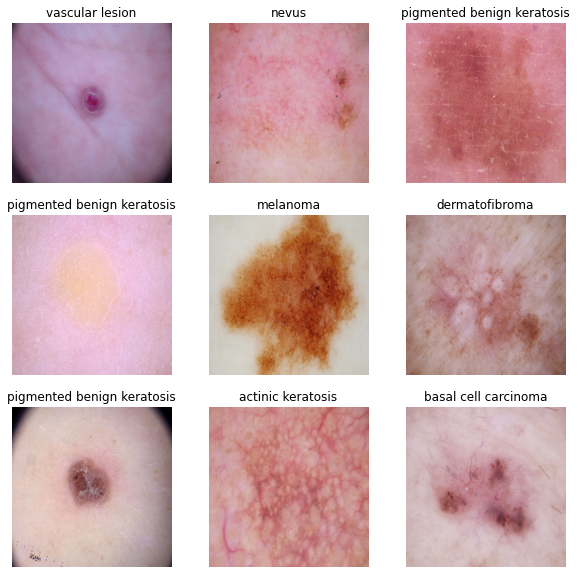

In [16]:
#### Create a code to visualize one instance of all the nine classes present in the dataset

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  # run it for each class
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

#### Model 1

In [18]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 71ms/step - loss: 1.9223 - accuracy: 0.2969 - val_loss: 1.6587 - val_accuracy: 0.4072
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5751 - accuracy: 0.4397 - val_loss: 1.4895 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3812 - accuracy: 0.5128 - val_loss: 1.4158 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3325 - accuracy: 0.5318 - val_loss: 1.3865 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1991 - accuracy: 0.5815 - val_loss: 1.3742 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1157 - accuracy: 0.6016 - val_loss: 1.4117 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0033 - accuracy: 0.6378 - val_loss: 1.3048 - val_accuracy: 0.5436
Epoch 8/20
5

### Visualizing training results

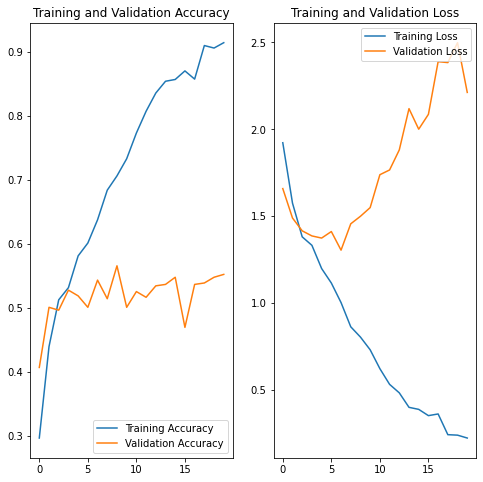

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
*   Big difference observed between Training and Validation accuracy.
*   The validation loss as observed is very high.
*   This could also be indicative of some **Overfit** in the model. 
*   We could add some Dropout layers and remove the BatchNormalization layers.
*   By adding a few more layers, we could improve the accuracy by trying to extract more features.


In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

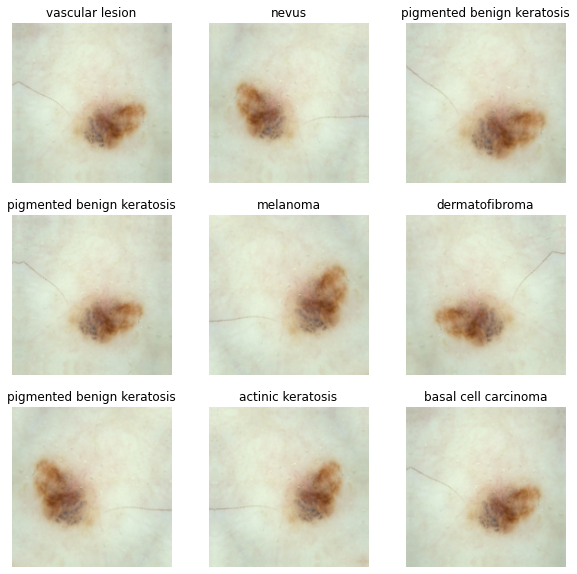

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Model 2


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
# history = ## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 30ms/step - loss: 2.0267 - accuracy: 0.2506 - val_loss: 1.9638 - val_accuracy: 0.2416
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.7683 - accuracy: 0.3493 - val_loss: 1.5745 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5389 - accuracy: 0.4526 - val_loss: 1.4687 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4275 - accuracy: 0.4883 - val_loss: 1.3900 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3999 - accuracy: 0.5028 - val_loss: 1.3606 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3184 - accuracy: 0.5318 - val_loss: 1.4557 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3001 - accuracy: 0.5346 - val_loss: 1.3526 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing the results

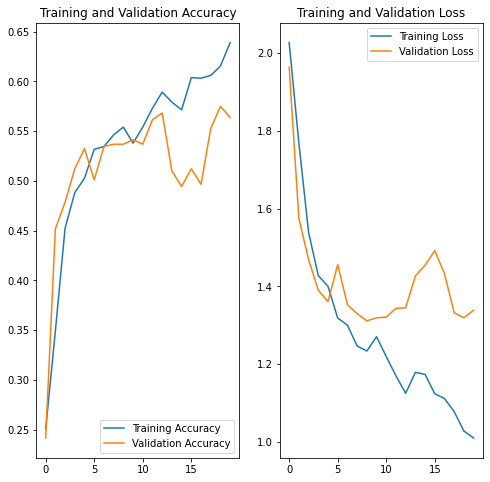

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:
*   This is a much better model compared to the previous one.
*   Difference between Training and Vaidation loss is not that big.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [30]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,vascular lesion
1,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2,Skin cancer ISIC The International Skin Imagin...,vascular lesion
3,Skin cancer ISIC The International Skin Imagin...,vascular lesion
4,Skin cancer ISIC The International Skin Imagin...,vascular lesion
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
2235,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
2236,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
2237,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma


Class=8, Class Name=basal cell carcinoma, n=139 (6.208%)
Class=5, Class Name=dermatofibroma, n=462 (20.634%)
Class=6, Class Name=pigmented benign keratosis, n=77 (3.439%)
Class=2, Class Name=pigmented benign keratosis, n=95 (4.243%)
Class=3, Class Name=pigmented benign keratosis, n=438 (19.562%)
Class=0, Class Name=vascular lesion, n=114 (5.092%)
Class=1, Class Name=nevus, n=376 (16.793%)
Class=4, Class Name=melanoma, n=357 (15.945%)
Class=7, Class Name=actinic keratosis, n=181 (8.084%)


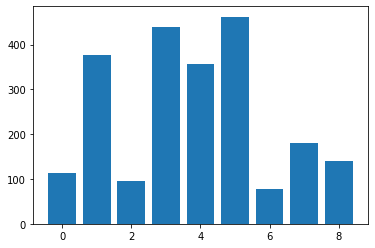

In [31]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, Class Name=%s, n=%d (%.3f%%)' % (k, class_names[labels[k]], v, per))

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### Observations:
*   Class imbalance found in the trainign dataset
*   Melanoma has maximum number of samples (462, 20.63%) whereas nevus has least number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
# We will use train folder here
path_to_training_dataset=train_path + "/"
import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6831D4D410>: 100%|██████████| 500/500 [00:17<00:00, 28.97 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6831463310>: 100%|██████████| 500/500 [00:16<00:00, 29.54 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F683148FED0>: 100%|██████████| 500/500 [00:20<00:00, 24.61 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F683144FF90>: 100%|██████████| 500/500 [01:21<00:00,  6.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F68314D1F90>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6831516C10>: 100%|██████████| 500/500 [00:17<00:00, 29.38 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6831524B50>: 100%|██████████| 500/500 [00:40<00:00, 12.38 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F683148F7D0>: 100%|██████████| 500/500 [00:16<00:00, 29.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F683148FF90>: 100%|██████████| 500/500 [00:16<00:00, 29.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_8dd144b8-2917-4895-8e6a-1004ae5c29f0.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029742.jpg_ef0cf1b7-95b3-4e38-ab08-9770e66122e7.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032775.jpg_50dcf248-2fcf-4d8e-af2b-c377c4aeb825.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027790.jpg_c472f700-bca8-4d0a-8d13-588f8f03f7a5.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024669.jpg_803af1f1-c480-42b9-9153-6c5109caafd4.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_o

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [37]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [39]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model 3



In [46]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [47]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [49]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 27s 52ms/step - loss: 1.8246 - accuracy: 0.3218 - val_loss: 1.5111 - val_accuracy: 0.4306
Epoch 2/50
169/169 [==============================] - 4s 25ms/step - loss: 1.3474 - accuracy: 0.5000 - val_loss: 1.2841 - val_accuracy: 0.5449
Epoch 3/50
169/169 [==============================] - 4s 25ms/step - loss: 1.1398 - accuracy: 0.5790 - val_loss: 1.1561 - val_accuracy: 0.5768
Epoch 4/50
169/169 [==============================] - 4s 24ms/step - loss: 0.9614 - accuracy: 0.6422 - val_loss: 1.0225 - val_accuracy: 0.6518
Epoch 5/50
169/169 [==============================] - 4s 24ms/step - loss: 0.7844 - accuracy: 0.7153 - val_loss: 0.9431 - val_accuracy: 0.6823
Epoch 6/50
169/169 [==============================] - 4s 24ms/step - loss: 0.6442 - accuracy: 0.7713 - val_loss: 0.9358 - val_accuracy: 0.6778
Epoch 7/50
169/169 [==============================] - 4s 24ms/step - loss: 0.5384 - accuracy: 0.8051 - val_loss: 0.8867 - val_accuracy: 0.7268
Epoch 8/5

#### **Todo:**  Visualize the model results

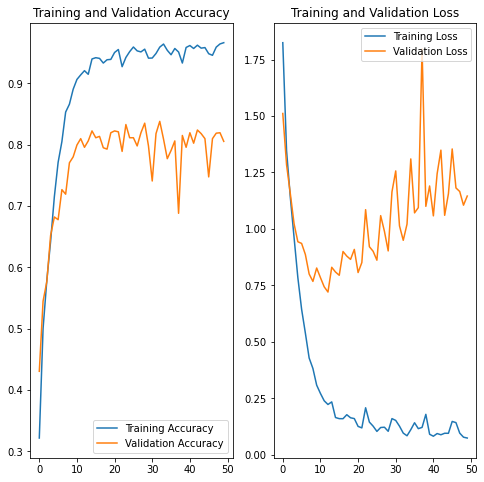

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Obeservations:
**Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


*    The training accuracy seems to be nearly ~90%.
*    The validation accuracy is nearly ~80%.
*    Though the model accuracy has improved, the class rebalance has helped treat the overfitting to some extent.
*    Much better models could be built or tried out using more epochs and more layers.



